In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import scipy.io as sio
from datetime import datetime
from datetime import datetime, timedelta

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import plot_ellipse, espra, moca, smooth, tilt_distance_LI

def deg_to_m(lat):
    R = 6371000
    rad = np.radians(lat)
    return (np.pi/180)*R*np.sqrt((np.cos(rad))**2 + 1)
    


#### IMOS Data

In [2]:
ssh_path = '/srv/scratch/z5297792/IN2023/2Drifter_Data/2Drifter_IMOS_Data.nc'
ssh_dataset = nc.Dataset(ssh_path, mode='r')

lon_ssh, lat_ssh = ssh_dataset['LONGITUDE'][:].data, ssh_dataset['LATITUDE'][:].data
lon_ssh, lat_ssh = np.meshgrid(lon_ssh, lat_ssh)
u_ssh, v_ssh = ssh_dataset['UCUR'][:].data, ssh_dataset['VCUR'][:].data # TIME, LATITUDE, LONGITUDE
u_ssh, v_ssh = np.transpose(u_ssh, axes=(2,1,0)), np.transpose(v_ssh, axes=(2,1,0)) # LON, LAT, TIME
tim_ssh = ssh_dataset['TIME'][:].data # days since 1985-01-01 00:00:00 UTC

ref_date = pd.Timestamp("1985-01-01 00:00:00")
tim_ssh = ref_date + pd.to_timedelta(tim_ssh, unit="D")

dic_ssh_data = {}
for t, time in enumerate(tim_ssh):
    ut, vt = u_ssh[:,:,t].T, v_ssh[:,:,t].T
    ut = np.where(np.abs(ut) < 4.9, ut, np.nan)
    vt = np.where(np.abs(vt) < 4.9, vt, np.nan)
    dic_ssh_data[time] = {'u': ut, 'v': vt}
    

#### SADCP Data

In [3]:
sadcp_data = sio.loadmat('/srv/scratch/z5297792/IN2023/sadcp.mat', simplify_cells=True)

z_sadcp = sadcp_data['z_sadcp']
u_sadcp = pd.DataFrame(sadcp_data['u_sadcp'], index=['u_' + str(z) for z in z_sadcp]).T
v_sadcp = pd.DataFrame(sadcp_data['v_sadcp'], index=['v_' + str(z) for z in z_sadcp]).T
lat_sadcp = sadcp_data['lat_sadcp']
lon_sadcp = sadcp_data['lon_sadcp']
tim_sadcp = sadcp_data['tim_sadcp']
julian_dates = tim_sadcp
ref_date = datetime(2000, 1, 1, 12)  # Julian day 2451545.0
gregorian_dates = [ref_date + timedelta(days=jd - 2451545.0) for jd in julian_dates]
tim_sadcp = gregorian_dates

df_sadcp = pd.DataFrame({'Time': tim_sadcp, 'Lon': lon_sadcp, 'Lat': lat_sadcp})

df_sadcp = pd.concat([df_sadcp, u_sadcp, v_sadcp], axis=1)


df_sadcp = df_sadcp[df_sadcp['Lat'] <= -37]
df_sadcp = df_sadcp.reset_index().drop(columns=['index'])

df_sadcp


,Time,Lon,Lat,u_27,u_37,u_47,u_57,u_67,u_77,u_87,...,v_717,v_727,v_737,v_747,v_757,v_767,v_777,v_787,v_797,v_807
0,2023-10-17 10:27:31.000004,154.357059,-37.005208,NaN,0.534412,0.569007,0.549270,0.465635,0.374654,0.323217,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-10-17 10:42:30.333327,154.360804,-37.038123,NaN,0.533096,0.555601,0.561888,0.484809,0.402146,0.357385,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-10-17 10:57:30.666685,154.364625,-37.071899,NaN,0.431565,0.456292,0.483472,0.458337,0.434674,0.398060,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-10-17 11:12:30.333340,154.368274,-37.101418,NaN,0.368063,0.378524,0.410269,0.398222,0.362505,0.358032,...,0.043875,0.044484,0.043708,0.042462,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-10-17 11:27:30.666659,154.372221,-37.104340,NaN,0.357789,0.368125,0.399916,0.385093,0.353109,0.356878,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,2023-10-21 21:27:30.333314,154.179344,-37.150309,NaN,0.246921,0.241454,0.244281,0.212926,0.202732,0.233854,...,0.056159,0.075346,0.080013,NaN,NaN,NaN,NaN,NaN,NaN,NaN
429,2023-10-21 21:42:30.666672,154.179347,-37.119931,NaN,0.222701,0.196322,0.206364,0.223129,0.236286,0.265476,...,0.056037,0.093465,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
430,2023-10-21 21:57:30.333327,154.179332,-37.088953,NaN,0.214721,0.206698,0.228885,0.243320,0.250907,0.249915,...,0.084378,0.079553,0.085535,NaN,NaN,NaN,NaN,NaN,NaN,NaN
431,2023-10-21 22:12:30.333314,154.179352,-37.058304,NaN,0.219740,0.226015,0.243559,0.245731,0.227310,0.231003,...,0.093274,0.105179,0.077085,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(np.float64(152.82463208333334),
 np.float64(155.61505402777777),
 np.float64(-38.949857916666666),
 np.float64(-36.912605972222224))

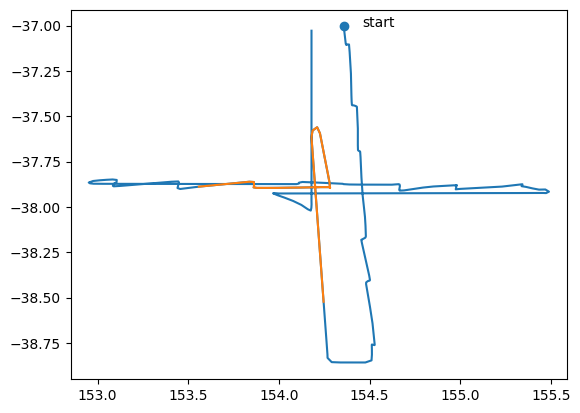

In [4]:
plt.plot(df_sadcp.Lon, df_sadcp.Lat)

t1 = pd.Timestamp('2023-10-19 6:00:00')
days1 = .4

df1 = df_sadcp[(df_sadcp.Time >= t1 - pd.Timedelta(days=days1)) & (df_sadcp.Time <= t1 + pd.Timedelta(days=days1))]
plt.plot(df1.Lon, df1.Lat)
plt.scatter(df_sadcp.Lon.iloc[0], df_sadcp.Lat.iloc[0])
plt.text(df_sadcp.Lon.iloc[0]+.1, df_sadcp.Lat.iloc[0], 'start')
plt.axis('equal')


In [5]:
u_cols = [col for col in df1.columns if 'u' in col]
v_cols = [col for col in df1.columns if 'v' in col]

df_espra = pd.DataFrame(columns=['xc', 'yc', 'w', 'Q', 'Rc', 'psi0', 'Depth'])
for (u_col, v_col) in zip(u_cols, v_cols):
    ui = df1[u_col]; vi = df1[v_col]
    xi, yi = df1.Lon, df1.Lat
    mask = ~np.isnan(xi) & ~np.isnan(yi) & ~np.isnan(ui) & ~np.isnan(vi)
    xi, yi, ui, vi = xi[mask], yi[mask], ui[mask], vi[mask]
    depth = int(u_col[2:])
    if (depth < 700) & (len(xi) > 2):
        xc, yc, w, Q, Rc, psi0 = espra(xi, yi, ui, vi)
        df_espra.loc[len(df_espra)] = {'xc': xc, 'yc': yc, 'w': w, 'Q': Q, 'Rc': Rc, 'psi0': psi0, 'Depth': depth}

from scipy.signal import savgol_filter
from scipy.interpolate import UnivariateSpline

def robust_smooth(y, x, win=5, poly=3, k=3.5, s=None):
    i = np.argsort(y); y0, x0 = y[i], x[i]
    x1 = savgol_filter(x0, win|1, poly, mode='interp')
    r = x0 - x1
    mad = np.median(np.abs(r - np.median(r))) + 1e-12
    mask = np.abs(r) <= k*1.4826*mad
    spl = UnivariateSpline(y0[mask], x0[mask], s=s)
    return spl(y0), y0, x0

df_espra['sRc'], _ , _ = robust_smooth(np.arange(len(df_espra)), df_espra.Rc)
df_espra['spsi0'], _ , _ = robust_smooth(np.arange(len(df_espra)), df_espra.psi0)

df_espra['sq11'], _ , _ = robust_smooth(np.arange(len(df_espra)), df_espra.Q.apply(lambda Q: Q[0,0]))
df_espra['sq12'], _ , _ = robust_smooth(np.arange(len(df_espra)), df_espra.Q.apply(lambda Q: Q[1,0]))
df_espra['sq22'], _ , _ = robust_smooth(np.arange(len(df_espra)), df_espra.Q.apply(lambda Q: Q[1,1]))

df_espra


,xc,yc,w,Q,Rc,psi0,Depth,sRc,spsi0,sq11,sq12,sq22
0,154.410295,-37.947232,-2.575222,"[[0.9065598591833207, 0.04887279392792032], [0...",0.741103,0.351444,37,0.737466,0.338992,0.872396,-0.003338,1.148409
1,154.419290,-37.939674,-2.526763,"[[0.9005218100634229, 0.02870615917953714], [0...",0.751485,0.354624,47,0.739870,0.341290,0.881698,-0.014349,1.137412
2,154.428868,-37.927534,-2.477813,"[[0.904565412442086, 0.005986355228668975], [0...",0.766232,0.361859,57,0.741979,0.343265,0.890145,-0.024289,1.127429
3,154.427421,-37.916905,-2.433567,"[[0.9179391794264996, -0.02036768929266454], [...",0.769166,0.358539,67,0.743800,0.344924,0.897763,-0.033198,1.118428
4,154.427481,-37.904148,-2.377242,"[[0.9185636625595782, -0.04588214097290583], [...",0.768932,0.349726,77,0.745338,0.346275,0.904582,-0.041114,1.110376
...,...,...,...,...,...,...,...,...,...,...,...,...
62,154.394610,-37.893024,-2.006474,"[[0.876482525162493, -0.07757943223104147], [-...",0.561579,0.156299,657,0.578706,0.159772,0.884407,-0.131862,1.149707
63,154.406310,-37.872131,-1.976915,"[[0.8834163547351224, -0.12404418043723922], [...",0.585830,0.166880,667,0.575338,0.156513,0.893333,-0.150011,1.139843
64,154.425209,-37.861439,-1.920417,"[[0.870032866913768, -0.15437373187741088], [-...",0.606308,0.172455,677,0.572086,0.153405,0.903130,-0.169500,1.128968
65,154.416667,-37.831495,-1.862903,"[[0.9173621199777299, -0.17726894245875263], [...",0.628271,0.180078,687,0.568956,0.150457,0.913826,-0.190367,1.117050


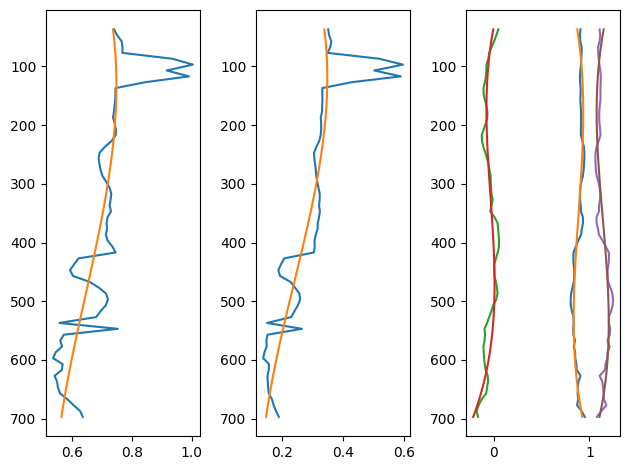

In [6]:
fig, axs = plt.subplots(1, 3)
axs[0].plot(df_espra.Rc, df_espra.Depth)
axs[0].plot(df_espra.sRc, df_espra.Depth)
axs[0].invert_yaxis()

axs[1].plot(df_espra.psi0, df_espra.Depth)
axs[1].plot(df_espra.spsi0, df_espra.Depth)
axs[1].invert_yaxis()

axs[2].plot(df_espra.Q.apply(lambda Q: Q[0,0]), df_espra.Depth)
axs[2].plot(df_espra.sq11, df_espra.Depth)
axs[2].plot(df_espra.Q.apply(lambda Q: Q[0,1]), df_espra.Depth)
axs[2].plot(df_espra.sq12, df_espra.Depth)
axs[2].plot(df_espra.Q.apply(lambda Q: Q[1,1]), df_espra.Depth)
axs[2].plot(df_espra.sq22, df_espra.Depth)
axs[2].invert_yaxis()

plt.tight_layout()
plt.show()


In [7]:
lon = np.linspace(df_sadcp.Lon.min(), df_sadcp.Lon.max())
lat = np.linspace(df_sadcp.Lat.min(), df_sadcp.Lat.max())
Lon, Lat = np.meshgrid(lon, lat)

U = np.zeros((Lon.shape[0], Lon.shape[1], len(df_espra)))
V = np.zeros((Lon.shape[0], Lon.shape[1], len(df_espra)))

for k in range(len(df_espra)):
    data = df_espra.iloc[k]
    
    dx, dy = Lon - data.xc, Lat - data.yc
    rho2 = data.sq11*dx**2 + 2*data.sq12*dx*dy + data.sq22*dy**2
    U[:,:,k] =   data.spsi0 * np.exp( - rho2 / data.sRc**2 ) * ( 2*data.sq12*dx + 2*data.sq22*dy ) / data.sRc**2
    V[:,:,k] = - data.spsi0 * np.exp( - rho2 / data.sRc**2 ) * ( 2*data.sq11*dx + 2*data.sq12*dy ) / data.sRc**2
    

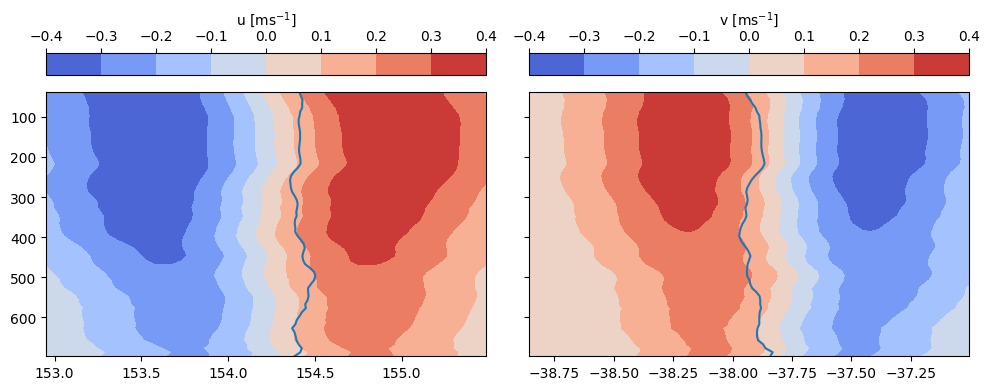

In [8]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 4))

xc_surf, yc_surf = df_espra.iloc[0].xc, df_espra.iloc[0].yc
ic_surf = np.argmin(np.abs(lon - xc_surf))
jc_surf = np.argmin(np.abs(lat - yc_surf))

c1 = axs[0].contourf(lon, df_espra.Depth, U[:, jc_surf, :].T, cmap='coolwarm')
axs[0].plot(df_espra.xc, df_espra.Depth)
c2 = axs[1].contourf(lat, df_espra.Depth, V[ic_surf, :, :].T, cmap='coolwarm')
axs[1].plot(df_espra.yc, df_espra.Depth)
axs[0].invert_yaxis()

fig.colorbar(c1, ax=axs[0], orientation='horizontal', location='top', label=r'u [ms$^{-1}$]')
fig.colorbar(c2, ax=axs[1], orientation='horizontal', location='top', label=r'v [ms$^{-1}$]')

plt.tight_layout()
plt.show()


In [9]:
df_espra

,xc,yc,w,Q,Rc,psi0,Depth,sRc,spsi0,sq11,sq12,sq22
0,154.410295,-37.947232,-2.575222,"[[0.9065598591833207, 0.04887279392792032], [0...",0.741103,0.351444,37,0.737466,0.338992,0.872396,-0.003338,1.148409
1,154.419290,-37.939674,-2.526763,"[[0.9005218100634229, 0.02870615917953714], [0...",0.751485,0.354624,47,0.739870,0.341290,0.881698,-0.014349,1.137412
2,154.428868,-37.927534,-2.477813,"[[0.904565412442086, 0.005986355228668975], [0...",0.766232,0.361859,57,0.741979,0.343265,0.890145,-0.024289,1.127429
3,154.427421,-37.916905,-2.433567,"[[0.9179391794264996, -0.02036768929266454], [...",0.769166,0.358539,67,0.743800,0.344924,0.897763,-0.033198,1.118428
4,154.427481,-37.904148,-2.377242,"[[0.9185636625595782, -0.04588214097290583], [...",0.768932,0.349726,77,0.745338,0.346275,0.904582,-0.041114,1.110376
...,...,...,...,...,...,...,...,...,...,...,...,...
62,154.394610,-37.893024,-2.006474,"[[0.876482525162493, -0.07757943223104147], [-...",0.561579,0.156299,657,0.578706,0.159772,0.884407,-0.131862,1.149707
63,154.406310,-37.872131,-1.976915,"[[0.8834163547351224, -0.12404418043723922], [...",0.585830,0.166880,667,0.575338,0.156513,0.893333,-0.150011,1.139843
64,154.425209,-37.861439,-1.920417,"[[0.870032866913768, -0.15437373187741088], [-...",0.606308,0.172455,677,0.572086,0.153405,0.903130,-0.169500,1.128968
65,154.416667,-37.831495,-1.862903,"[[0.9173621199777299, -0.17726894245875263], [...",0.628271,0.180078,687,0.568956,0.150457,0.913826,-0.190367,1.117050


154.41029505600693 -37.94723154293799


(np.float64(152.82463208333334),
 np.float64(155.61505402777777),
 np.float64(-38.949857916666666),
 np.float64(-36.912605972222224))

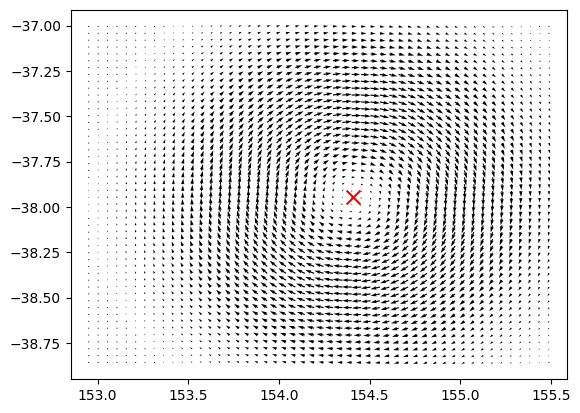

In [10]:
k = 0

data = df_espra.iloc[k]
plt.quiver(Lon, Lat, U[:,:,k], V[:,:,k])
plt.scatter(data.xc, data.yc, marker='x', s=100, color='r')
print(data.xc, data.yc)
plt.axis('equal')


In [11]:
TD, *_ = tilt_distance_LI(df_espra.xc, df_espra.yc, df_espra.Depth)
TD*110


np.float64(22.275596489776476)

#### Generalise

In [23]:
xc_approx, yc_approx = 154.41029505600693, -37.94723154293799

# for days in np.arange(.1, 1.6, .1):
days = .7
    

start = (df_sadcp.Time.min() + pd.Timedelta(days=days)).round('h')
end   = (df_sadcp.Time.max() - pd.Timedelta(days=days)).round('h')
times = pd.date_range(start, end, freq='12h')

dic_tframe = {}
n = 0
for t in times:

    df_tframe = df_sadcp[(df_sadcp.Time >= t - pd.Timedelta(days=days)) & (df_sadcp.Time <= t + pd.Timedelta(days=days))]

    u_cols = [col for col in df_tframe.columns if 'u' in col]
    v_cols = [col for col in df_tframe.columns if 'v' in col]
    
    df_espra_tframe = pd.DataFrame(columns=['xc', 'yc', 'w', 'Q', 'Rc', 'psi0', 'Depth'])
    for (u_col, v_col) in zip(u_cols, v_cols):
        ui = df_tframe[u_col]; vi = df_tframe[v_col]
        xi, yi = df_tframe.Lon, df_tframe.Lat
        mask = ~np.isnan(xi) & ~np.isnan(yi) & ~np.isnan(ui) & ~np.isnan(vi)
        xi, yi, ui, vi = xi[mask], yi[mask], ui[mask], vi[mask]
        depth = int(u_col[2:])
        if (depth < 700) & (len(xi) > 2):
            xc, yc, w, Q, Rc, psi0 = espra(xi, yi, ui, vi)
            if np.hypot(xc - xc_approx, yc - yc_approx) < .2:
                df_espra_tframe.loc[len(df_espra_tframe)] = {'xc': xc, 'yc': yc, 'w': w,
                                                         'Q': Q, 'Rc': Rc, 'psi0': psi0, 'Depth': depth}
                
    if len(df_espra_tframe):
        dic_tframe[t] = df_espra_tframe
        n += 1
# print(n, days)
print(f'{n} successful profiles using {days} day intervals')


6 successful profiles using 0.7 day intervals


6


(-38.857255555555554, -37.005208333333336)

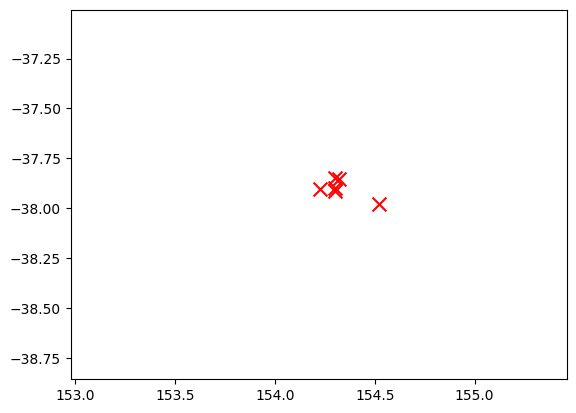

In [26]:
k = 0

n = 0
for df in dic_tframe.values():
    if len(df)-1 >= k:
        data = df.iloc[k]
        plt.scatter(data.xc, data.yc, marker='x', s=100, color='r')
        n += 1
print(n)
plt.axis('equal')
plt.xlim(Lon.min(), Lon.max())
plt.ylim(Lat.min(), Lat.max())


2023-10-18 03:00:00
2023-10-18 15:00:00
2023-10-19 03:00:00
2023-10-20 03:00:00
2023-10-20 15:00:00
2023-10-21 03:00:00
0 6
2023-10-18 03:00:00
2023-10-18 15:00:00
2023-10-19 03:00:00
2023-10-20 03:00:00
2023-10-20 15:00:00
2023-10-21 03:00:00
1 6
2023-10-18 03:00:00
2023-10-18 15:00:00
2023-10-19 03:00:00
2023-10-20 03:00:00
2023-10-20 15:00:00
2 5
2023-10-18 03:00:00
2023-10-18 15:00:00
2023-10-19 03:00:00
2023-10-20 03:00:00
2023-10-20 15:00:00
3 5
2023-10-18 03:00:00
2023-10-18 15:00:00
2023-10-19 03:00:00
2023-10-20 03:00:00
2023-10-20 15:00:00
4 5
2023-10-18 03:00:00
2023-10-18 15:00:00
2023-10-19 03:00:00
2023-10-20 03:00:00
2023-10-20 15:00:00
5 5
2023-10-18 03:00:00
2023-10-18 15:00:00
2023-10-19 03:00:00
2023-10-20 03:00:00
2023-10-20 15:00:00
6 5
2023-10-18 03:00:00
2023-10-18 15:00:00
2023-10-19 03:00:00
2023-10-20 03:00:00
2023-10-20 15:00:00
7 5
2023-10-18 03:00:00
2023-10-18 15:00:00
2023-10-19 03:00:00
2023-10-20 03:00:00
2023-10-20 15:00:00
8 5
2023-10-18 03:00:00
2023

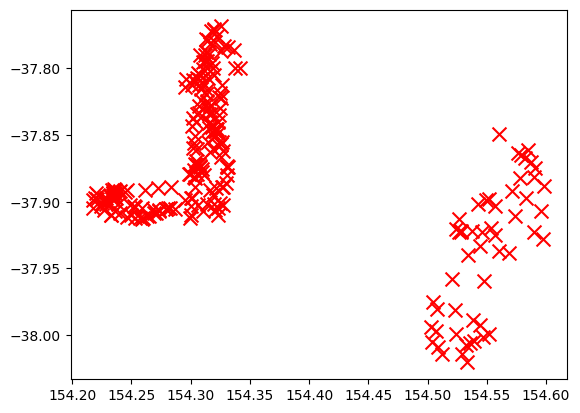

In [25]:
for k in range(70):
    n = 0
    for time, df in zip(dic_tframe.keys(), dic_tframe.values()):
        if len(df)-1 >= k:
            data = df.iloc[k]
            plt.scatter(data.xc, data.yc, marker='x', s=100, color='r')
            print(time)
            n += 1
    print(k, n)
    

In [32]:
good_ts = [pd.Timestamp('2023-10-18 03:00:00'),
            pd.Timestamp('2023-10-18 15:00:00'),
            pd.Timestamp('2023-10-19 03:00:00'),
            pd.Timestamp('2023-10-20 03:00:00'),
            pd.Timestamp('023-10-20 15:00:00')]

dic_good = {}
for t in good_ts:
    dic_good[t] = dic_tframe[t]
    

KeyError: Timestamp('23-10-20 15:00:00')

In [33]:
dic_tframe.keys()

dict_keys([Timestamp('2023-10-18 03:00:00'), Timestamp('2023-10-18 15:00:00'), Timestamp('2023-10-19 03:00:00'), Timestamp('2023-10-20 03:00:00'), Timestamp('2023-10-20 15:00:00'), Timestamp('2023-10-21 03:00:00')])